In [1]:
# general
import boto3
import datetime as dt
import json
import numpy as np
import pandas as pd
import snowflake.connector

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

### 0.2 : Connection to Snowflake

In [3]:
from abc import ABCMeta, abstractmethod

class Credentials(metaclass=ABCMeta):
    pass
    
    
class SSMPSCredentials(Credentials):
    def __init__(self, secretid: str):
        self._secretid = secretid
        self._secrets = {}
        
    def get_keys(self):
        """
        credential fetching 
        """
        _aws_sm_args = {'service_name': 'secretsmanager', 'region_name': 'us-east-1'}
        secrets_client = boto3.client(**_aws_sm_args)
        get_secret_value_response = secrets_client.get_secret_value(SecretId=self._secretid)
        return get_secret_value_response
    
    
class BaseConnector(metaclass=ABCMeta):
    @abstractmethod
    def connect(self):
        raise NotImplementedError
    

class SnowflakeConnector(BaseConnector):
    def __init__(self, credentials: Credentials):
        keys = credentials.get_keys()
        self._secrets = json.loads(keys.get('SecretString', "{}"))

    def connect(self, dbname: str, schema: str = 'DEFAULT'):
        ctx = snowflake.connector.connect(
            user=self._secrets['login_name'],
            password=self._secrets['login_password'],
            account=self._secrets['account'],
            warehouse=self._secrets['warehouse'],
            database=dbname,
            schema=schema
        )

        return ctx
    
## Credentials
SF_CREDS = 'datascience-max-dev-sagemaker-notebooks'

## Snowflake connection 
conn=SnowflakeConnector(SSMPSCredentials(SF_CREDS))
ctx=conn.connect("MAX_DEV","WORKSPACE")

def run_query(query):
    cursor = ctx.cursor()
    cursor.execute(query)
    df = pd.DataFrame(cursor.fetchall(), columns = [desc[0] for desc in cursor.description])
    df.columns= df.columns.str.lower()
    return df

/home/ec2-user/anaconda3/envs/python3/lib/python3.6/site-packages/boto3/compat.py:88: PythonDeprecationWarning: Boto3 will no longer support Python 3.6 starting May 30, 2022. To continue receiving service updates, bug fixes, and security updates please upgrade to Python 3.7 or later. More information can be found here: https://aws.amazon.com/blogs/developer/python-support-policy-updates-for-aws-sdks-and-tools/
  warnings.warn(warning, PythonDeprecationWarning)


In [6]:
revenue = pd.read_csv('Revenue.csv', encoding = "ISO-8859-1")
revenue.rename(columns = {'Company':'platform'}, inplace = True)
revenue['platform'] = revenue['platform'].replace('Amazon', 'Amazon Prime Video')
revenue.head()

,Region,Country,platform,Business Line,Business model,Distribution/Technology,Digital/Analogue,Year,Quarter,Value
0,North America,USA,Acorn TV,Subscription OTT,Subscription,OTT,NaN,2027,Q4,"23,637"
1,North America,USA,Acorn TV,Subscription OTT,Subscription,OTT,NaN,2027,Q3,"23,514"
2,North America,USA,Acorn TV,Subscription OTT,Subscription,OTT,NaN,2027,Q2,"23,390"
3,North America,USA,Acorn TV,Subscription OTT,Subscription,OTT,NaN,2027,Q1,"23,269"
4,North America,USA,Acorn TV,Subscription OTT,Subscription,OTT,NaN,2026,Q4,"23,149"


In [15]:
subscriber = pd.read_csv('Subscription.csv', encoding = "ISO-8859-1")

In [8]:
revenue_2022 = revenue[(revenue['platform'].isin(['Amazon Prime Video', 'Apple TV+', 'Discovery+', 'Disney+', 'Hulu',
                                                'Netflix', 'Paramount+', 'Peacock', 'HBO Max', 'Showtime', 'Starz']))
                      &(revenue['Year'] == 2022)
                      &(revenue['Quarter'] == 'Q4')].copy()

In [16]:
subscriber = subscriber.rename(columns = {'Date':'date', 'Service':'platform'})
subscriber = subscriber[subscriber['Distributor'] == 'All']
subscriber = subscriber[(subscriber['platform'].isin(['Amazon Prime Video', 'Apple TV+', 'Discovery+', 'Disney+', 'Hulu',
                                                'Netflix', 'Paramount+', 'Peacock', 'HBO Max', 'Showtime', 'Starz']))]
subscriber['date'] = pd.to_datetime(subscriber['date'])

In [19]:
revenue_2022['Value'] = revenue_2022['Value'].str.replace(',', '').astype(int)

In [18]:
num_cols = ['Sign-ups', 'Subscribers', 'Net Subscriber Adds', 'Gross Subscriber Adds', 'Cancels']
for n in num_cols:
    subscriber[n] = pd.to_numeric(subscriber[n].str.replace(',', ''), errors='coerce')

In [20]:
subscriber.head()

,date,platform,Distributor,Sign-ups (Indexed),Subscribers (Indexed),Net Subscriber Adds (Indexed),Gross Subscriber Adds (Indexed),Cancels (Indexed),Sign-ups,Subscribers,Net Subscriber Adds,Gross Subscriber Adds,Cancels
0,2019-11-01,Apple TV+,All,2.10,0.74,0.74,0.74,NaN,892778,315770,315770,315770,NaN
1,2019-12-01,Apple TV+,All,0.78,1.03,0.28,0.39,0.104,330183,436132,120361,164637,44275.0
2,2020-01-01,Apple TV+,All,0.68,1.41,0.39,0.56,0.173,287725,600899,164767,238256,73489.0
3,2020-02-01,Apple TV+,All,0.34,2.13,0.71,0.95,0.235,145161,904074,303176,402893,99717.0
4,2020-03-01,Apple TV+,All,0.50,2.24,0.12,0.40,0.282,214106,954193,50118,169960,119842.0


In [10]:
title_popularity = run_query('''
SELECT imdb_id, SUM(PAGE_VIEWS) AS total_page_views
FROM max_prod.ckg.wikipedia_page_views_media
WHERE DATE >= '2022-10-01'
AND DATE < '2023-01-01'
AND LANGUAGE = 'en'
GROUP BY 1
''')

In [11]:
title_availabity = run_query('''
SELECT DISTINCT 
       imdb.ORIGINAL_TITLE as title,
       imdb.title_id as IMDB_ID,
       amp_o.PLATFORM,
       imdb.PRODUCTION_RELEASE_DATE as PRODUCTION_RELEASE_DATE,
       imdb.NUMBER_OF_VOTES,
       imdb.IMDB_RATING,
       amp_o.country,
       amp_meta.CONTENT_TYPE,
       amp_meta.PRIMARY_GENRE,
       amp_meta.SECONDARY_GENRE,
       amp_o.IN_HOUSE,
       amp_meta.SCRIPTED,
       CASE WHEN CONTAINS(amp_meta.ORIGINAL, 'Original') THEN 'Yes' Else 'No' END AS IS_ORIGINAL,
       amp_meta.PRIMARY_PRODUCTION_COMPANY,
       amp_meta.PRIMARY_PRODUCTION_PARENT_COMPANY,
       amp_meta.PRIMARY_PRODUCTION_COUNTRY
FROM "MAX_PROD"."CKG"."IMDB_TITLE" imdb 
JOIN "MAX_PROD"."CKG"."AMPERE_METADATA"amp_meta ON imdb.title_id = amp_meta.imdb_id
JOIN "MAX_PROD"."CKG"."AMPERE_OCCURRENCE" amp_o ON  amp_meta.content_pid = amp_o.content_pid 
WHERE 1=1
and amp_meta.CONTENT_TYPE in ('TVShow', 'Movie')
and amp_o.month IN ('Oct-2022', 'Nov-2022', 'Dec-2022')
and amp_o.PLATFORM in ('Amazon Prime Video', 'Apple TV+', 'Discovery+', 'Disney+', 'Hulu', 'Netflix', 'Paramount+', 'Peacock', 'HBO', 'HBO Max')
and amp_o.COUNTRY = 'USA'
--GROUP BY 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16
''')

In [12]:
title_popularity = title_popularity[title_popularity['imdb_id'].isin(title_availabity.imdb_id)]

In [13]:
title_availabity = title_availabity.merge(title_popularity, on = ['imdb_id'], how = 'left')

# Signup and Churn trend

In [22]:
subsriber_add_month = subscriber[['date', 'platform', 'Subscribers']].copy()
subsriber_add_month['date'] = subsriber_add_month.date + pd.DateOffset(months=1)
subsriber_add_month.rename(columns = {'Subscribers':'total_subscribers'}, inplace = True)

In [23]:
subscriber = subscriber.merge(subsriber_add_month, on = ['date', 'platform'], how = 'left')
subscriber['churn_rate'] = subscriber['Cancels']/subscriber['total_subscribers']

In [35]:
subscriber.head()

,date,platform,Distributor,Sign-ups (Indexed),Subscribers (Indexed),Net Subscriber Adds (Indexed),Gross Subscriber Adds (Indexed),Cancels (Indexed),Sign-ups,Subscribers,Net Subscriber Adds,Gross Subscriber Adds,Cancels,total_subscribers,churn_rate
0,2019-11-01,Apple TV+,All,2.10,0.74,0.74,0.74,NaN,892778,315770,315770,315770,NaN,NaN,NaN
1,2019-12-01,Apple TV+,All,0.78,1.03,0.28,0.39,0.104,330183,436132,120361,164637,44275.0,315770.0,0.140213
2,2020-01-01,Apple TV+,All,0.68,1.41,0.39,0.56,0.173,287725,600899,164767,238256,73489.0,436132.0,0.168502
3,2020-02-01,Apple TV+,All,0.34,2.13,0.71,0.95,0.235,145161,904074,303176,402893,99717.0,600899.0,0.165946
4,2020-03-01,Apple TV+,All,0.50,2.24,0.12,0.40,0.282,214106,954193,50118,169960,119842.0,904074.0,0.132558


In [33]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

In [34]:
subscriber=subscriber.sort_values(by = ['platform', 'date'])

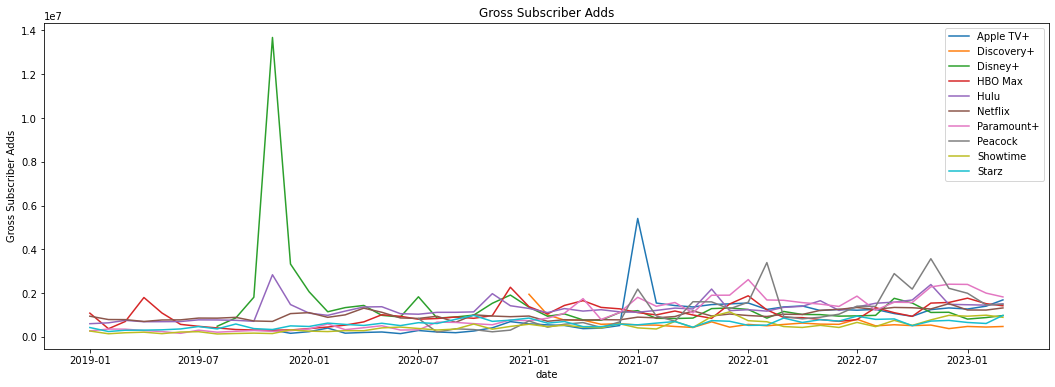

In [37]:
plot_df = subscriber[['date', 'platform', 'Gross Subscriber Adds', 'churn_rate']]

fig, ax = plt.subplots(figsize=(18, 6))
for p in plot_df.platform.unique():
    row = plot_df[plot_df['platform'] == p]
    plt.plot(row['date'], row['Gross Subscriber Adds'], label = p)
    
plt.title('Gross Subscriber Adds')
plt.xlabel('date')
plt.ylabel('Gross Subscriber Adds')
plt.legend()
plt.show()

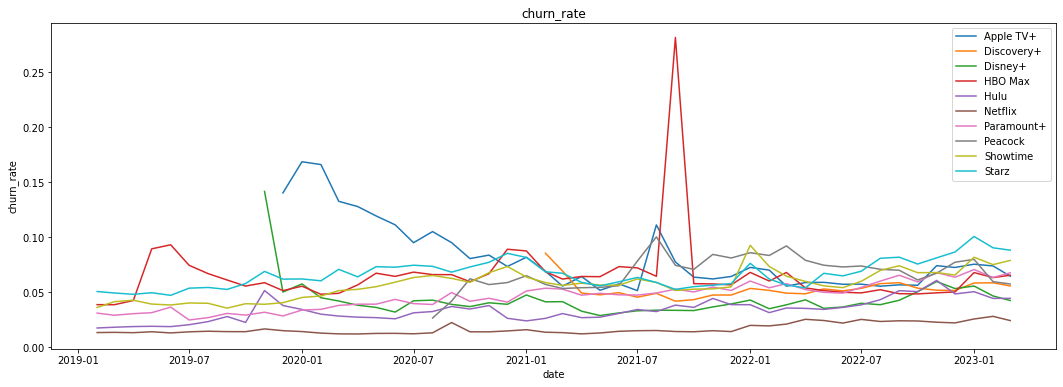

In [38]:
fig, ax = plt.subplots(figsize=(18, 6))
for p in plot_df.platform.unique():
    row = plot_df[plot_df['platform'] == p]
    plt.plot(row['date'], row['churn_rate'], label = p)
    
plt.title('churn_rate')
plt.xlabel('date')
plt.ylabel('churn_rate')
plt.legend()
plt.show()